In [21]:
# -*- coding: utf-8 -*-
"""
FULL GRAPH   (fixed bipartite bug)
----------------------------------
"""

import pandas as pd, networkx as nx, numpy as np
from datetime import timedelta
from tqdm import tqdm

try:
    import community as community_louvain      # python-louvain
except ImportError:
    raise RuntimeError("pip install python-louvain")

# -------------------------------------------------
# 1. LOAD
# -------------------------------------------------
clients = pd.read_csv('data/clients.csv')
tx      = pd.read_csv('data/bank_transactions.csv',
                      parse_dates=['datetime'])

tx['device_type'] = tx['device_type'].fillna('unknown')
tx['merchant']    = tx['merchant'].fillna('no_merchant')
tx['dt_30']       = tx['datetime'].dt.floor('30min')

# -------------------------------------------------
# 2. BUILD BIPARTITE GRAPH
# -------------------------------------------------
B = nx.Graph()

def ensure_client(node_id):
    "добавить клиентский узел с метаданными, если ещё нет"
    if not B.has_node(node_id):
        B.add_node(node_id, ntype='client', bipartite=0)

# все клиенты из справочника
for cid in clients['client_id']:
    ensure_client(cid)

# конфигурация «столбец → (префикс, базовый вес)»
HUBS = {
    'merchant'    : ('m',   1.0),
    'session_id'  : ('sess',0.5),
    'ip_address'  : ('ip',  0.7),
    'device_type' : ('dev', 0.3),
    'region'      : ('reg', 0.2),
}

for col, (pref, w_base) in HUBS.items():
    for cid, hub_val in tx[['client_id', col]].dropna().itertuples(index=False):
        ensure_client(cid)
        hub = f"{pref}:{hub_val}"
        B.add_node(hub, ntype=pref, bipartite=1)
        B.add_edge(cid, hub, etype=f'share_{pref}', weight=w_base)

# withdrawal / deposit как «ATM-хабы»
atm_rows = tx.query("transaction_type in ['withdrawal','deposit']") \
             [['client_id','region','dt_30','transaction_type']]

for cid, region, dt30, ttype in atm_rows.itertuples(index=False):
    ensure_client(cid)
    hub = f"atm:{region}:{dt30}"
    B.add_node(hub, ntype='atm', bipartite=1)
    w = 0.8 if ttype=='withdrawal' else 0.6
    B.add_edge(cid, hub, etype=f'{ttype}_atm', weight=w)

# -------------------------------------------------
# 3. DIRECTED P2P LAYER
# -------------------------------------------------
P2P = nx.DiGraph()
for s, r, amt, ts in tx.loc[tx.transaction_type=='p2p',
                            ['client_id','recipient_id','amount','datetime']].itertuples(index=False):
    if pd.isna(r):              # защитимся от NaN
        continue
    ensure_client(s)
    ensure_client(r)
    P2P.add_edge(s, r, etype='p2p', amount=amt, datetime=ts)

# -------------------------------------------------
# 4. CLIENT-CLIENT PROJECTION
# -------------------------------------------------
client_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 0}

proj = nx.algorithms.bipartite.weighted_projected_graph(B, client_nodes)

# логарифмическая нормализация
for u, v, d in proj.edges(data=True):
    d['weight'] = np.log1p(d['weight'])

# -------------------------------------------------
# 5. MERGE WITH P2P  ➜ FINAL GRAPH
# -------------------------------------------------
G = nx.Graph()
G.add_nodes_from(proj.nodes(data=True))
G.add_edges_from((u, v, dict(d, layer='shared')) for u, v, d in proj.edges(data=True))

for u, v, d in P2P.edges(data=True):
    w = np.log1p(d['amount'])
    if G.has_edge(u, v):
        G[u][v]['weight']      += w
        G[u][v]['p2p_count']    = G[u][v].get('p2p_count', 0) + 1
    else:
        G.add_edge(u, v, weight=w, layer='p2p', p2p_count=1)

# обрезаем «слабые» рёбра
G.remove_edges_from([e for e in G.edges(data=True) if e[2]['weight'] < 1])

def graph_brief(g):
    n, m = g.number_of_nodes(), g.number_of_edges()
    density = nx.density(g)
    avg_deg = 2*m / n if n else 0
    return (f"Graph: |V|={n:,}  |E|={m:,}  "
            f"density={density:.4f}  avg_deg={avg_deg:.2f}")

print(graph_brief(G))


# -------------------------------------------------
# 6. METRICS & COMMUNITY
# -------------------------------------------------
deg = dict(G.degree(weight='weight'))
nx.set_node_attributes(G, deg, 'w_degree')

btw = nx.betweenness_centrality(G, k=min(500, len(G)), weight='weight', seed=1)
nx.set_node_attributes(G, btw, 'betweenness')

part = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, part, 'louvain_comm')

# вывод статистики
sizes = pd.Series(part).value_counts()
print("Top-10 community sizes:", sizes.head(10).to_dict())

# -------------------------------------------------
# 7. SAVE
# -------------------------------------------------
nx.write_graphml(G, 'client_graph.graphml')
pd.Series(deg, name='weighted_degree').to_csv('node_degree.csv')

print("✓ Graph saved to client_graph.graphml")
print("✓ Degrees saved to node_degree.csv")


Graph: |V|=1,206  |E|=489,969  density=0.6743  avg_deg=812.55
Top-10 community sizes: {2: 272, 1: 267, 3: 224, 0: 210, 5: 177, 45: 1, 50: 1, 49: 1, 47: 1, 46: 1}
✓ Graph saved to client_graph.graphml
✓ Degrees saved to node_degree.csv


|                     |                0 |
|:--------------------|-----------------:|
| nodes               |   1206           |
| edges               | 489969           |
| density             |      0.674317    |
| avg_weighted_degree |    812.55        |
| avg_clustering      |      0.0409733   |
| diameter_LCC        |      3           |
| modularity_louvain  |      0.0571416   |
| modularity_lp       |      1.22518e-11 |


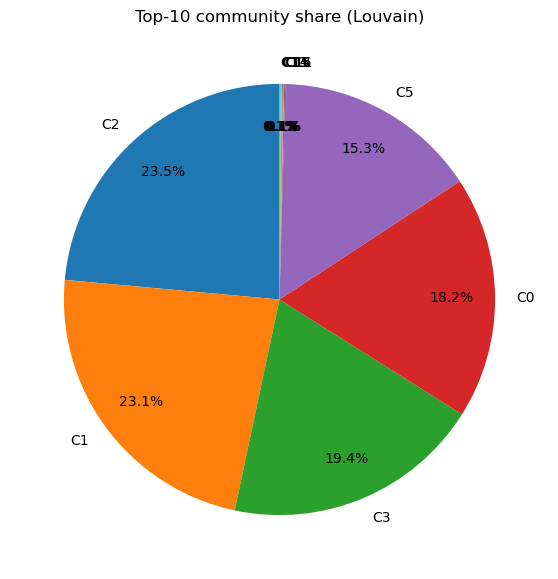

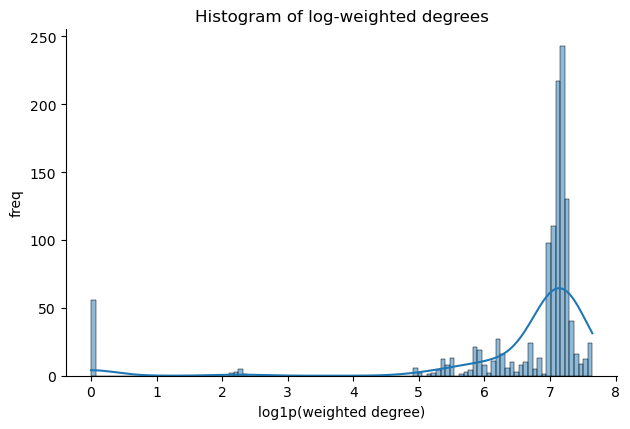

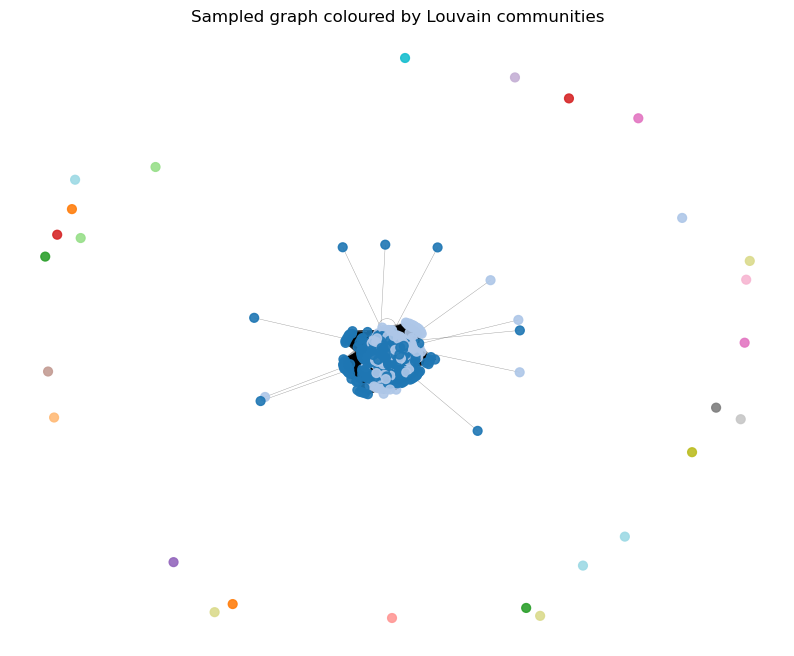

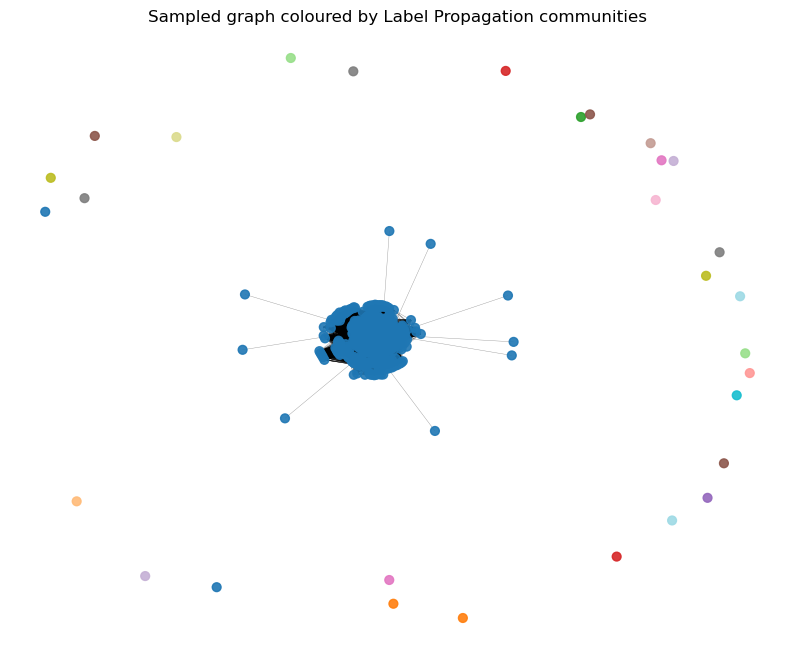

In [22]:
# VISUAL_ANALYTICS.PY
# -------------------
import networkx as nx, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from networkx.algorithms.community import label_propagation_communities
from pylab import rcParams
from community import modularity         # из python-louvain
import random, warnings; warnings.filterwarnings("ignore")

# ---- 1. сообщества Louvain (уже считаны ранее) --------------
louvain = nx.get_node_attributes(G, 'louvain_comm')      # из прошлого скрипта

# если не считано – считаем
if not louvain:
    import community as community_louvain
    louvain = community_louvain.best_partition(G, weight='weight')
    nx.set_node_attributes(G, louvain, 'louvain_comm')

# ---- 2. Label Propagation -----------------------------------
if 'lp_comm' not in nx.get_node_attributes(G, 'lp_comm'):
    lp_raw = list(label_propagation_communities(G))
    lp_map = {}
    for i, comm in enumerate(lp_raw):
        for node in comm:
            lp_map[node] = i
    nx.set_node_attributes(G, lp_map, 'lp_comm')
else:
    lp_map = nx.get_node_attributes(G, 'lp_comm')

# ---- 3. Метрики графа ---------------------------------------
n  = G.number_of_nodes();  m = G.number_of_edges()
density      = nx.density(G)
avg_deg      = round(2*m/n, 2)
avg_clust    = nx.average_clustering(G, weight='weight')
largest_cc   = max(nx.connected_components(G), key=len)
diameter_lcc = nx.diameter(G.subgraph(largest_cc))
lou_mod      = modularity(louvain, G, weight='weight')
lp_mod       = modularity(lp_map, G, weight='weight')

metrics = pd.Series({
    'nodes'              : n,
    'edges'              : m,
    'density'            : density,
    'avg_weighted_degree': avg_deg,
    'avg_clustering'     : avg_clust,
    'diameter_LCC'       : diameter_lcc,
    'modularity_louvain' : lou_mod,
    'modularity_lp'      : lp_mod
})
print(metrics.to_markdown())

# ---- 4. Pie-chart размеров сообществ (Louvain) --------------
sizes = pd.Series(louvain).value_counts().sort_values(ascending=False)
top10 = sizes.head(10)
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(top10, labels=[f'C{c}' for c in top10.index],
       autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax.set_title('Top-10 community share (Louvain)')
plt.show()

# ---- 5. Гистограмма лог-взвешенной степени ------------------
deg = pd.Series(dict(G.degree(weight='weight')))
sns.displot(np.log1p(deg), kde=True, height=4, aspect=1.6)
plt.title('Histogram of log-weighted degrees')
plt.xlabel('log1p(weighted degree)');  plt.ylabel('freq')
plt.show()

# ---- 6. Функция выборочной визуализации графа ---------------
def draw_subgraph(comm_attr, comm_name, k=700):
    # берём k случайных узлов + их соседей
    base_nodes = random.sample(list(G.nodes), min(k, len(G)))
    nbrs = set(base_nodes)
    for n in base_nodes:
        nbrs.update(G[n])
    SG = G.subgraph(nbrs).copy()

    # выбираем цвет по сообществу
    comms = nx.get_node_attributes(G, comm_attr)
    colors = [comms.get(v, -1) for v in SG.nodes()]
    cmap = plt.cm.get_cmap('tab20')

    pos = nx.spring_layout(SG, seed=42, k=0.2)
    rcParams['figure.figsize'] = 10,8
    plt.figure()
    nx.draw_networkx_nodes(SG, pos,
                           node_size=40,
                           node_color=colors,
                           cmap=cmap,
                           alpha=0.9)
    nx.draw_networkx_edges(SG, pos,
                           width=0.3,
                           alpha=0.4)
    plt.title(f"Sampled graph coloured by {comm_name} communities")
    plt.axis('off')
    plt.show()

draw_subgraph('louvain_comm', 'Louvain')
draw_subgraph('lp_comm',      'Label Propagation')
